# The QR Algorithm, Gram-Schmidt, and finding communities in complex networks


Preamble: Run the cells below to import the necessary Python packages

Open this notebook in Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/qr_eigenvalues.ipynb)

<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

In [3]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


## Eigensystems

We can think of the "natural" coordinate system for a matrix as the set of eigenvectors. For Hermitian matrices, we can always rotate a collection of vectors, but the eigenspectrum gives us the dominant directions and scales associated with a bundle. Under a dynamical systems view, a "blob" of initial conditions gets anisotropically stretched along the eigendirections at different rates proportional to the eigenvalues.

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/strain_axes.png" style="max-width:50%; height:auto;">

<br>
<br>
<br>


# Finding eigenspectra is difficult for large matrices

Suppose we are given a square matrix $A \in \mathbb{R}^{N \times N}$. How can we find the eigenvalues and eigenvectors of this matrix numerically? The schoolyard method for performing this calculation consists of first solving the characteristic equation for the eigenvalues $\lambda$ such that
$$
\det(A - \lambda \mathbb I) = 0.
$$
Calculation of the determinant has runtime complexity $\sim N^3$, making computation of the characteristic polynomial itself no harder than matrix multiplication. However, the hard part is factoring the characteristic equation into a form amenable to finding the eigenvalues, $(\lambda - \lambda_1)(\lambda - \lambda_2)...(\lambda - \lambda_N) = 0$.  Since the polynomial has order $\mathcal{O}(\lambda^N)$, at large $N$, it often becomes impractical to use numerical root-finding to solve the eigenvalue problem using schoolyard methods.

<br>
<br>


## Iterative numerical linear algebra

Iterative numerical linear algebra methods are a class of algorithms that gradually build up a solution to a problem by making small changes to an initial guess. These methods are particularly useful for large matrices, where the schoolyard method for finding the eigenvalues and eigenvectors is too slow. They have more predictable time cost (complexity input agnostic), are easier to control precision/runtime, and potentially faster in cases with fast convergence. They are also easier to parallelize and can exploit sparsity.

However, they are also indirect and approximate, and so they don't always converge to the exact solution. Bad starting conditions or ill-conditioning can lead to a large prefactor in the runtime to reach a given target accuracy.

<br>
<br>

## QR Factorization and Gram Schmidt orthogonalization

Classical schoolyard methods for matrix inversion via Gauss-Jordan elimination could be summarized as a single matrix, the $L^{-1}$ of LU factorization. The runtime complexity of this process is thus $\mathcal{O}(N^3)$, which is the same as the runtime complexity of matrix multiplication.

In a similar vein, we can summarize the QR factorization and Gram-Schmidt orthogonalization as a single matrix, the $Q$ and $R$ matrices of QR factorization. The runtime complexity of this process is thus also $\mathcal{O}(N^3)$.

We will use Gram-Schmidt orthogonalization to build up an orthonormal basis from a bundle of vectors. Other orthogonalization methods (Givens rotations, Householder triangularization) exist as well.

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/qr.png" style="max-width:50%; height:auto;">

*Image from [Source](https://dsc-spidal.github.io/harp/docs/harpdaal/qr/)*

To illustrate the traditional Gram-Schmidt algorithm, we start by picking two vectors $\mathbf{v}_1$ and $\mathbf{v}_2$ and orthogonalizing them. We first pick one of the vectors, which we can call the "pivot" vector, and normalize it to get the first column of our orthonormal basis $Q$.

$$
\mathbf{q}_1 = \frac{\mathbf{v}_1}{\|\mathbf{v}_1\|}
$$

We then project the second vector onto the first vector and subtract the projection from the second vector to get the second column of $Q$.

$$
\mathbf{q}_2 = \frac{\mathbf{v}_2 - \mathbf{v}_2 \cdot \mathbf{q}_1}{\|\mathbf{v}_2 - \mathbf{v}_2 \cdot \mathbf{q}_1\|}
$$




(-1.0, 1.0)

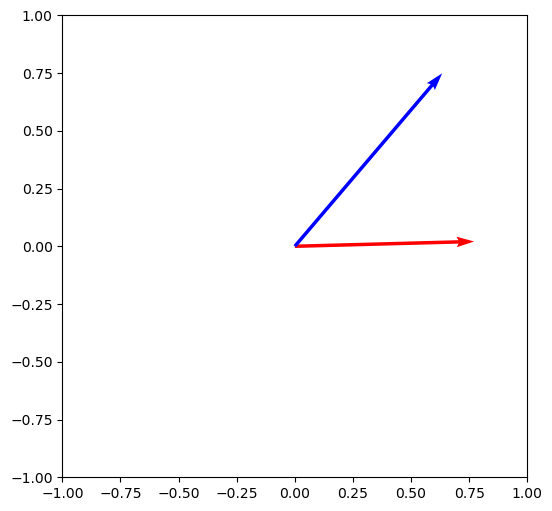

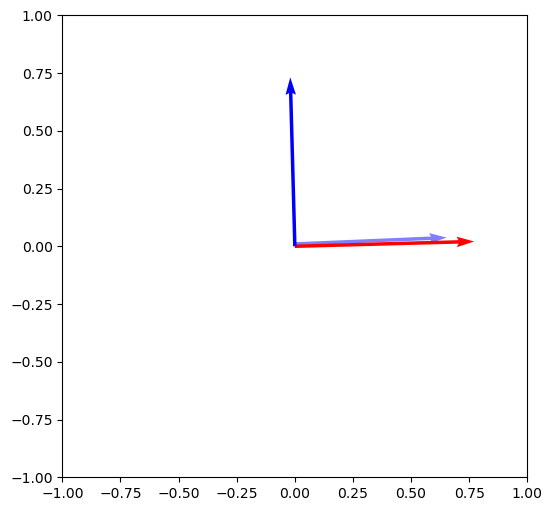

In [6]:
## Sample and plot two random vectors
np.random.seed(10)
vec1, vec2 = np.random.rand(2), np.random.rand(2)
plt.figure(figsize=(6, 6))
plt.quiver(0, 0, vec1[0], vec1[1], angles='xy', scale_units='xy', scale=1, color='r')
plt.quiver(0, 0, vec2[0], vec2[1], angles='xy', scale_units='xy', scale=1, color='b')
plt.xlim(-1, 1)
plt.ylim(-1, 1)



## # Project vec2 onto vec1, and then scale vec1 by the ratio of the
##  projection to the length of vec1
vec2_proj_onto_vec1 = np.dot(vec2, vec1) / np.dot(vec1, vec1) * vec1

# # # Subtract the projection from vec2
vec2_orth = vec2 - vec2_proj_onto_vec1


plt.figure(figsize=(6, 6))
# # Draw the projection, add a small offset to avoid overlapping vectors
plt.quiver(
    0, 1e-2, vec2_proj_onto_vec1[0], vec2_proj_onto_vec1[1] + 1e-2, 
    angles='xy', scale_units='xy', scale=1, color='b', alpha=0.5) 

# # # Draw the orthogonalized vector
plt.quiver(0, 0, vec1[0], vec1[1], angles='xy', scale_units='xy', scale=1, color='r')
plt.quiver(0, 0, vec2_orth[0], vec2_orth[1], angles='xy', scale_units='xy', scale=1, color='b')
plt.xlim(-1, 1)
plt.ylim(-1, 1)



What if we wanted to invert this process? We can walk through the steps of the Gram-Schmidt process

$[\mathbf{v}_1, \mathbf{v}_2]$ are our starting vectors, and  $[\mathbf{q}_1, \mathbf{q}_2]$ are our orthogonalized vectors.

We can recover the first vector by writing

$$
\mathbf{v}_1 = \mathbf{q}_1 (\mathbf{v}_1 \cdot \mathbf{q}_1) + \mathbf{q}_2 (0)
$$

We can recover the second vector by writing

$$
\mathbf{v}_2 = \mathbf{q}_1 (\mathbf{v}_2 \cdot \mathbf{q}_1) + \mathbf{q}_2 (\mathbf{v}_2 \cdot \mathbf{q}_2)
$$

We can therefore store the parenthetical scalar terms in their own matrix, $R$, and write the above equations as

$$
\begin{bmatrix}
\mathbf{v}_1 & \mathbf{v}_2
\end{bmatrix} =
\begin{bmatrix}
\mathbf{q}_1 & \mathbf{q}_2
\end{bmatrix}
\begin{bmatrix}
R_{11} & R_{12} \\
0 & R_{22}
\end{bmatrix}
$$
where $R_{ij} = \mathbf{v}_i \cdot \mathbf{q}_j$.

In [8]:
# Create a matrix with vec1 and vec2 as columns
A = np.array([vec1, vec2]).T

# Normalize the "first" vector to get q1, the first unit vector
vec1_norm = np.linalg.norm(vec1)
q1 = vec1 / vec1_norm

# Normalize the orthogonal vector to get q2
vec2_orth_norm = np.linalg.norm(vec2_orth)
q2 = vec2_orth  / vec2_orth_norm 

# Construct the Q matrix, which is the matrix of unit vectors. The first column
# points in the same direction as vec1
Q = np.array([q1, q2]).T

# Construct the R matrix
R = np.zeros((2, 2))
R[0, 0] = vec1_norm
R[0, 1] = np.dot(q1, vec2)
R[1, 1] = vec2_orth_norm

# R is the matrix of projections onto the previous vectors
# R = np.array([[np.dot(vec1, vec1), np.dot(vec1, vec2)], [0, np.dot(vec2_orth, vec2_orth)]])

# Check that Q and R recreate A
print('Q = \n', Q)
print('R = \n', R)
print('Q @ R = \n', Q @ R)
print('A = \n', A)

## Check that Q and R recreate A
print(np.allclose(A, Q @ R))

Q = 
 [[ 0.99963827 -0.02689471]
 [ 0.02689471  0.99963827]]
R = 
 [[0.77159975 0.65355789]
 [0.         0.73149124]]
Q @ R = 
 [[0.77132064 0.63364823]
 [0.02075195 0.74880388]]
A = 
 [[0.77132064 0.63364823]
 [0.02075195 0.74880388]]
True


For non-square matrices, we might append extra orthogonal columns to $Q$ and zeros to $R$, so that $Q$ now represents a full-rank matrix with rowsspace spanning its full columnspace

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/qr_reduced.png" style="max-width:50%; height:auto;">

The steps of the Gram-Schmidt algorithm are as follows:

1. Pick a column vector $\mathbf{v}_1$ from the matrix $A$ and normalize it to have unit length. This will be the first column $\mathbf{q}_1$ of the matrix $Q$. We will keep a running partial $Q$ matrix, $Q_k \in \mathbb{R}^{N \times k}$. After this step, $Q_1 = \mathbf{q}_1 \in \mathbb{R}^{N \times 1}$. We store the normalization factor as well, $r_{11} = \|\mathbf{v}_1\|$.


2. Move to the next column vector $\mathbf{v}_2$ of $A$. Subtract the projection of $\mathbf{v}_2$ onto $\mathbf{q}_1$ from $\mathbf{v}_2$. Normalize the resulting vector to get the second column of $Q$.

    $$
    \mathbf{q}_2 = \mathbf{v}_2 - Q_1^T \mathbf{v}_2
    $$

    $$
    \mathbf{q}_2 \leftarrow \frac{\mathbf{q}_2}{\|\mathbf{q}_2\|}
    $$

    We cache the projection factor, $r_{21} = Q_1^T \mathbf{v}_2$, as well as the normalization factor, $r_{22} = \|\mathbf{q}_2\|$.

3. Move to the third column vector $\mathbf{v}_3$ of $A$. Subtract the projection of $\mathbf{v}_3$ onto $\mathbf{q}_1$ *and* the projection of $\mathbf{v}_3$ onto $\mathbf{q}_2$. Normalize the resulting vector to get the third column of $Q$. We can do this concisely by performing a single matrix-vector multiplication with the running partial $Q$ matrix:

    $$
        \mathbf{q}_3 \leftarrow \mathbf{v}_3 - Q_2^T \mathbf{v}_3
    $$

    $$
        \mathbf{q}_3 \leftarrow \frac{\mathbf{q}_3}{\|\mathbf{q}_3\|}
    $$

    We cache the normalization factor, $r_{33} = \|\mathbf{q}_3\|$, but we also cache both projection factors, $[r_{31}, r_{32}] = Q_1^T \mathbf{v}_3$


3. Repeat steps 1 and 2 for the remaining columns of $A$ to build the full $Q$ and $R$ matrices.

So. in traditional Gram-Schmidt, once we've passed a column and normalized it, we never touch it again. All future columns are orthogonalized with respect to the columns we've already processed. By the time we get to the last column of an $N \times N$ matrix, we need to subtract $N-1$ projections from it to orthogonalize it.

In [ ]:
def qr_factorization(X):
    """
    Compute the QR factorization of a square matrix using iterative Gram-Schmidt 
    orthonormalization.

    Args:
        X (numpy.ndarray): A square matrix.
        
    Returns:
        Q (numpy.ndarray): An orthonormal matrix.
        R (numpy.ndarray): The upper triangular matrix.

    """

    X = X.T # want first index to be the column index (for convenience)
    Qk = list()
    R = np.zeros(X.shape) # Initialize an empty matrix to store projection factors

    ## Pick first vector as the "pivot" and normalize it
    q1 = X[0] / np.linalg.norm(X[0])
    Qk.append(q1) # Add the first vector to the list of Qk

    ## Project rest of the vectors onto the pivot to fill out the first column of Q
    R[0, 0] = np.linalg.norm(X[0])

    for i in range(1, X.shape[0]):
        
        ## Project the ith vector of X onto all previous vectors in Qk
        qi = X[i] - np.sum(np.dot(X[i], np.array(Qk[:i]).T) * np.array(Qk[:i]).T, axis=-1)
        R[i, i] = np.linalg.norm(qi) # store the normalization factor

        ## Normalize the orthogonalized vector  
        qi /= np.linalg.norm(qi)

        ## Update the upper triangular matrix R
        R[i, :i] = np.dot(X[i], np.array(Qk[:i]).T)
        
        ## Add the orthogonalized vector to the list of Qk
        Qk.append(qi)  

    ## Transpose the Q and R matrices to get the correct format
    Q, R = np.array(Qk).T, R.T
    return Q, R


We can now test that our QR factorization is correct. We will use numpy's built-in `allclose` function to check that the product of the Q and R matrices is equal to the original matrix to within some small tolerance.

In [33]:
A = np.random.normal(size=(10, 10))
q, r = qr_factorization(A)

np.allclose(A, q @ r)

True

# Eigenspectrum estimation via the QR eigenvalue method

How do we get the eigenspectrum of a matrix using QR factorization? Recall that rotating a matrix does not change its eigenvalues. The orthogonal basis $Q$ returned by QR factorization is a rotation matrix, and so the eigenvalues of $A$ are the same as the eigenvalues of $R = Q^T A Q$. Recall that, for orthogonal matrices, $Q^T = Q^{-1}$.

We can therefore repeatedly rotate the matrix $A$ using QR factorization until it becomes diagonal, in which case the diagonal entries are the eigenvalues of $A$. We therefore have an iterative algorithm for computing the eigenvalues and eigenvectors of a symmetric matrix $A$,

1. We compute the QR factorization of $A_k$ to get $Q_k$ and $R_k$.
$$
    Q_k, R_k \leftarrow \text{QR}(A_k)
$$

2. We then form a new matrix $A_{k+1}$ by reversing the order of multiplication of $Q_k$ and $R_k$. Since $Q_k$ is a rotation matrix and $R_k$ is a triangular matrix, this new matrix has the same spectrum as $A_k$
$$
    A_{k+1} \leftarrow R_k Q_k
$$

3. We accumulate the rotation matrix $T_k$ by multiplying the previous rotation matrix by $Q_k$
    $$
        T_{k+1} \leftarrow T_k Q_k,
    $$
    where $T_0 = \mathbb{I}$. This will allow us to track the cumulative rotation of $A$ as we iterate.

4. We repeat steps 1-3 until the matrix $A_k$ is diagonalized. The eigenvalues are then given by the diagonal entries of $A_k$, and the eigenvectors are given by the columns of $T_k$.

<!-- ### Why does this work?

Recall that $R$ is a triangular matrix with non-zero entries given by $\mathbf{v}_i \cdot \mathbf{q}_j$. The rotations associated with a given intermediate $Q_k$ gradually push the off-diagonal elements of $R$ to zero.
### Our implementation -->


### Implementing the QR eigenvalue algorithm in Python

Here, we are going to implement the QR algorithm in Python. Note that numpy, as in other languages, uses row, column format for indexing. Since we often interpret a matrix as an array of column vectors, selecting the ith column vector of a matrix `a` has the form `a[:, i]`. By convention, eigenvectors are returned in a format where the columns are eigenvectors, and so we select individual eigenvectors along the second axis.

We can break our implementation into several stages:

1. Implementing QR factorization. We can use either the Gram-Schmidt algorithm or Householder reflections to compute the QR factorization.
2. Computing an eigensystem via repeated QR factorization and transformation

In [34]:
class QREigendecomposition:
    """
    A numpy implementation of the QR eigenvalue algorithm for symmetric matrices

    Attributes:
        eigenvalues (numpy.ndarray): The eigenvalues of the matrix.
        eigenvectors (numpy.ndarray): The eigenvectors of the matrix, stored as columns.
        store_intermediate (bool): Whether to store the intermediate matrices.
    """

    def __init__(self, store_intermediate=False):
        self.eigenvalues = None
        self.eigenvectors = None
        self.store_intermediate = store_intermediate

    def qr_factorization(self, X):
        """
        Compute the QR factorization of a square matrix using Gram-Schmidt 
        orthonormalization.

        Args:
            X (numpy.ndarray): A square matrix.
            
        Returns:
            Q (numpy.ndarray): An orthonormal matrix.
            R (numpy.ndarray): The upper triangular matrix.

        """

        X = X.T # want first index to be the column index (for convenience)

        q, r = np.zeros(X.shape), np.zeros(X.shape) # preallocate
        q[0] = X[0] / np.linalg.norm(X[0])
        r[0] = X @ q[0]
        for i in range(1, X.shape[0]):
            q[i] = X[i] - np.sum(np.dot(X[i], q[:i].T) * q[:i].T, axis=-1)
            q[i] /= np.linalg.norm(q[i])

            ## Update the upper triangular matrix R
            r[i, i:] = X[i:] @ q[i]
        
        q = q.T # because we took transpose beforehand for easier indexing
        return q, r

    def find_eigensystem(self, X, max_iter=2000, tol=1e-6):
        """
        Find the eigenvalues and eigenvectors of a matrix

        Args:
            X (numpy.ndarray): A square matrix.
            max_iter (int): The maximum number of iterations to perform.
            tol (float): The tolerance for convergence.

        Returns:
            eigenvalues (numpy.ndarray): The eigenvalues of the matrix.
        """
        prev = np.copy(X)
        tq = np.identity(X.shape[0])
        if self.store_intermediate: self.intermediate = [np.copy(X)]
        for i in range(max_iter):
            q, r = self.qr_factorization(X)
            
            X = r @ q # q^-1 x q
            # np.matmul(r, q)
            # np.dot(r.T, q)
            # np.einsum('ij,jk->ik', r, q)

            tq = tq @ q # accumulate the eigenvector matrix

            if self.store_intermediate: self.intermediate.append(np.copy(X))

            ## Check for convergence and stop early if converged
            if np.linalg.norm(X - prev) < tol:
                break
            prev = np.copy(X)
        eigenvalues, eigenvectors = np.diag(X), tq
        sort_inds = np.argsort(eigenvalues)
        eigenvalues, eigenvectors = eigenvalues[sort_inds], eigenvectors[:, sort_inds]
        self.eigenvalues, self.eigenvectors = eigenvalues, eigenvectors
        return eigenvalues, eigenvectors



We can start by checking whether our QR factorization implementation finds the same eigenvalues as numpy's built-in function.

False


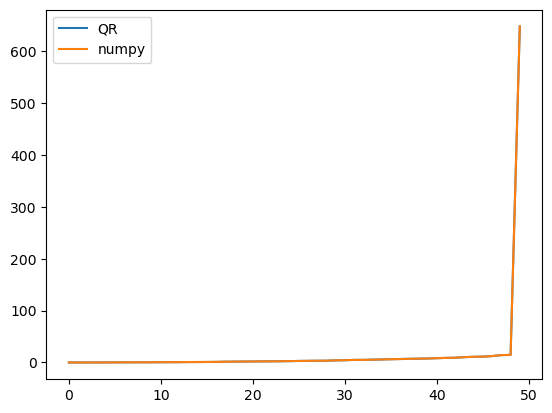

In [99]:
a = np.random.random((50, 50))
a = a @ a.T # ensure symmetric

model = QREigendecomposition(store_intermediate=True)
eigenvalues, eigenvectors = model.find_eigensystem(a)

plt.figure()
plt.plot(eigenvalues, label="QR")
plt.plot(np.linalg.eigh(a)[0], label="numpy")
plt.legend()

print(np.allclose(eigenvalues, np.linalg.eigh(a)[0]))

We can get a sense of why the QR algorithm works by plotting the intermediate $R_k$ matrices. Recall that those measure the projections of the current matrix $A_k$ onto the orthonormal basis $Q_k$. The off-diagonal elements of $R_k$ thus quantify the distance from orthogonality in the current basis.

Text(0, 0.5, 'Norm of off-diagonal elements of $R_k$')

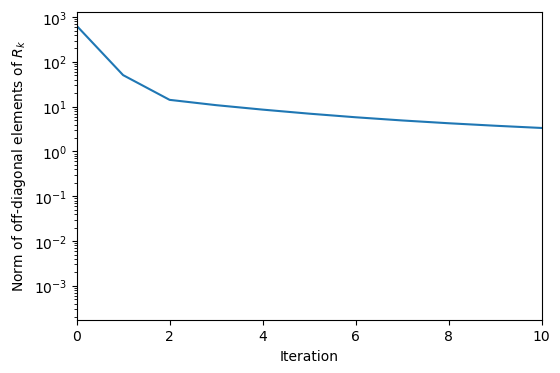

In [100]:
all_r = [model.qr_factorization(X)[1] for X in model.intermediate]

plt.figure(figsize=(6, 4))
plt.semilogy([np.linalg.norm(R - np.diag(np.diag(R))) for R in all_r])
plt.xlim(0, 10)
plt.xlabel("Iteration")
plt.ylabel("Norm of off-diagonal elements of $R_k$")

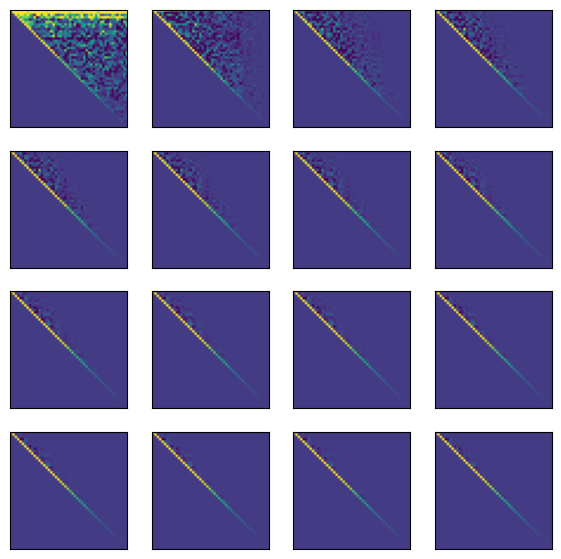

In [102]:
plt.figure(figsize=(7, 7))
for i, r in enumerate(all_r[:16]):
    plt.subplot(4, 4, i+1)
    plt.imshow(r, vmin=np.percentile(all_r[0], 5), vmax=np.percentile(all_r[0], 95))
    plt.xticks([]); plt.yticks([])

In [ ]:
## Make a video of the intermediate $R_k$ matrices

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
im = ax.imshow(all_r[0], vmin=np.percentile(all_r[0], 5), vmax=np.percentile(all_r[0], 95))
title = ax.set_title(f"R_0")

def update_frame(frame_idx):
    im.set_data(all_r[frame_idx])
    title.set_text(f"R_{frame_idx}")
    return (im, title)

anim = FuncAnimation(fig, update_frame, frames=len(all_r[:50]), interval=200, blit=False)

html = HTML(anim.to_jshtml(default_mode="loop"))



plt.rcParams["animation.html"] = "jshtml"  # use JS-based display (no ffmpeg needed)
plt.close(fig)  # avoid a duplicate static figure
display(anim)   # or: HTML(anim.to_jshtml(default_mode="loop"))




#### Why does this algorithm work? 

For a full-rank matrix $A$, we can always find an orthonormal matrix via QR factorization using a method such as Gram-Schmidt orthonormalization. The $Q$ matrix represents the basis, and the upper-triangular $R$ matrix represents the weights necessary to project the original matrix $A$ into the orthogonal basis. 

Recall that the eigenvalues of a matrix are invariant to changes in basis, and so the $Q$ matrix acts like a rotation of the eigenvectors. When we perform the transformation $R Q$, we are essentially calculating $Q^{-1} A Q$. This essentially represents a change of basis, which gradually aligns the columns of $A$ with the eigenvectors, resulting in an upper-triangular form where we can just read the eigenvalues off the diagonal. 

Moreover, because a composition of rotations is still a rotation, but keeping track of the net rotation in the matrix $T_k$, we can immediately read off the eigenbasis for the system.

For a more technical description of this algorithm, as well as explicit definition of the Gram-Schmidt orthonormalization process, we refer to Chapter 11 of William Press's Numerical Recipes textbook, as well as these [lecture notes by Peter Arbenz](https://people.inf.ethz.ch/arbenz/ewp/Lnotes/chapter4.pdf). It's possible to generalize the QR algorithm to work for non-symmetric matrices with complex eigenvalues. However, this implementation is pretty subtle. A good discussion is provided in the [Watkins textbook](https://www.wiley.com/en-us/Fundamentals+of+Matrix+Computations%2C+3rd+Edition-p-9780470528334)


<!-- ## What to do next

+ Instead of using Gram-Schmidt, try implementing orthonormalization using Householder reflections. -->

In [105]:

# Let's do a simple unit test to make sure that our class is working as expected
import unittest

class TestQR(unittest.TestCase):
    
    def test_factorization(self):
        """
        Test that the QR factorization is correct
        """
        np.random.seed(0)
        a = np.random.random((20, 20))
        model = QREigendecomposition()
        q, r = model.qr_factorization(a)  
        self.assertTrue(np.allclose(a, q @ r), "QR factorization failed")

    def test_eigenvalues(self):
        """
        Test that the eigenvalues are correct against numpy's built-in function
        """
        np.random.seed(0)
        a = np.random.random((20, 20))
        a = a @ a.T # make sure it's symmetric
        model = QREigendecomposition()
        eigenvalues, _ = model.find_eigensystem(a)
        self.assertTrue(np.allclose(eigenvalues, np.linalg.eigh(a)[0]), "Eigenvalues are incorrect")

    def test_eigenvectors(self):
        """
        Test that the eigenvectors are correct against numpy's built-in function
        """
        np.random.seed(0)
        a = np.random.random((5, 5))
        a = a @ a.T # make sure it's symmetric
        model = QREigendecomposition()
        _, eigenvectors = model.find_eigensystem(a)
        ## We have to take the absolute value of the eigenvectors because the eigenvectors
        ## are not unique up to a sign.
        self.assertTrue(
            np.allclose(np.abs(eigenvectors), np.abs(np.linalg.eigh(a)[1])), 
            "Eigenvector calculation failed"
        )


unittest.main(argv=[''], exit=False)


...
----------------------------------------------------------------------
Ran 3 tests in 0.031s

OK


In [106]:
## Make an interactive video
from ipywidgets import interact, Layout
import ipywidgets as widgets

def plotter(i):
    amat = model.intermediate[i] 
    amat /= np.linalg.norm(model.intermediate[i], axis=0, keepdims=True)
    plt.figure()
    plt.plot([0, amat[:, 0][0]], [0, amat[:, 0][1]])
    plt.plot([0, amat[:, 1][0]], [0, amat[:, 1][1]])
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, 10, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=10), Output()), _d…

<function __main__.plotter(i)>

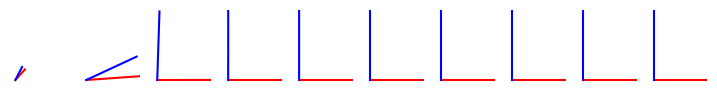

In [107]:
## Show the process of A becoming orthogonal
plt.figure(figsize=(9, 1))
for i, amat in enumerate(model.intermediate[:10]):

    vec1, vec2 = amat[:, 0], amat[:, 1]
    plt.subplot(1, 10, i+1)
    plt.plot([0, vec1[0]], [0, vec1[1]], color='red')
    plt.plot([0, vec2[0]], [0, vec2[1]], color='blue')
    plt.xlim(-0.1, 1)
    plt.ylim(-0.1, 1)
    plt.axis('off')

### Classical Gram-Schmidt struggles on ill-conditioned matrices

We will create a nearly-singular matrix by first defining a singular matrix, and then adding a small amount of noise to each column vector. We can then compute the QR factorization of the matrix, and see how close the product of the Q and R matrices is to the original matrix.

In [122]:
np.random.seed(0)
a = np.random.random(4)

for amp in [1.0, 1e-12]:
    aa = np.vstack([
        a + amp * np.random.random(4),
        a + amp * np.random.random(4),
        a + amp * np.random.random(4),
        a + amp * np.random.random(4),
    ]).T
    
    print("Condition number: ", np.linalg.cond(aa))
    q, r = qr_factorization(aa)
    
    print("Error: ", np.linalg.norm(q @ r - aa))
    print("\n")

Condition number:  16.462375346067077
Error:  0.0


Condition number:  81921498003963.52
Error:  1.1102230246251565e-16




#### Idea: we want to start dis-aligning the column vectors as early as possible in the iterative algorithm

We know that ill-conditioning occurs when the column vectors are close to being parallel. We therefore want to start dis-aligning the column vectors as early as possible in the iterative algorithm.  The moment we find a unit vector basis element, we immediately remove it from *all* of the remaining vectors in our set $X$. Recall the *curse of dimensionality*: in higher dimensions, the condition number tends to be larger, and so the Gram-Schmidt process can be numerically unstable.

Another way to think about this: the Gram-Schmidt process is a series of projections. In traditional Gram-Schmidt in high-dimensions, we subtract from the last vector a bunch of very small terms (because the last vector will likely already be close to orthogonal to the previous vectors).

<br>
<br>
<br>
<br>


## Modified Gram-Schmidt decomposition

We can mitigate the effect of nearly parallel column vectors by performing the projections and subtractions in a different order. To understand this, we will write out the first few steps of the Gram-Schmidt process for both the traditional and modified versions.

**Traditional Gram-Schmidt**

1. Pick the first column vector and normalize it to form the first unit vector $\mathbf{q}_1$

2. Project vector 2 onto vector 1, multiply by unit vector 1, and then subtract the resulting vector from vector 1

    $$
        \mathbf{v}_2 = \mathbf{v}_2 - (\mathbf{v}_2 \cdot \mathbf{q}_1) \mathbf{q}_1
    $$

3. Normalize vector 2. Now move to the third column vector, then project to find its components along unit vector 1 AND unit vector 2, then subtract both

    $$
        \mathbf{v}_3 = \mathbf{v}_3 - (\mathbf{v}_3 \cdot \mathbf{q}_1) \mathbf{q}_1 - (\mathbf{v}_3 \cdot \mathbf{q}_2) \mathbf{q}_2
    $$


This approach becomes unstable in high-dimensions, because at later steps we are subtracting a large number of small terms. As a result, the elements of the residual vector can become very small before we apply the re-normalization step, leading to numerical errors.

In **Modified Gram-Schmidt**, we perform the steps in a different order, which allows us to re-normalize after each subtraction of a pair of vectors. 

1. Pick the first column vector and normalize it.

3. Pick *all remaining column vectors*, and subtract their projections onto the first column vector.
    $$
        \mathbf{v}_2 = \mathbf{v}_2 - (\mathbf{v}_2 \cdot \mathbf{q}_1) \mathbf{q}_1
    $$

    $$
        \mathbf{v}_3 = \mathbf{v}_3 - (\mathbf{v}_3 \cdot \mathbf{q}_1) \mathbf{q}_1
    $$

    $$
        \dots
    $$

    $$
        \mathbf{v}_N = \mathbf{v}_N - (\mathbf{v}_N \cdot \mathbf{q}_1) \mathbf{q}_1
    $$


Besides the order in which we normalize and sweep, the key difference is the step where we compute projections between previously-determined unit-vectors. In the modified Gram-Schmidt, the projection occurs between the latest $i^{th}$ unit vector and a column vector $j > i$ where the previous $i - 1$ unit vectors have already been subtracted out. As a result, our dot product is less likely to be very small, because all of the $i-1$ previous shared basis vectors have already been removed by the time we compute the dot product.

In general, numerical operations behave better when the involved vectors are further from parallel. Modified Gram-Schmidt sidesteps finding the dot product between two nearly-aligned vectors.

True


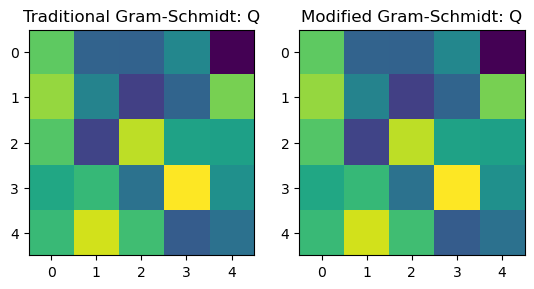

<Figure size 640x480 with 0 Axes>

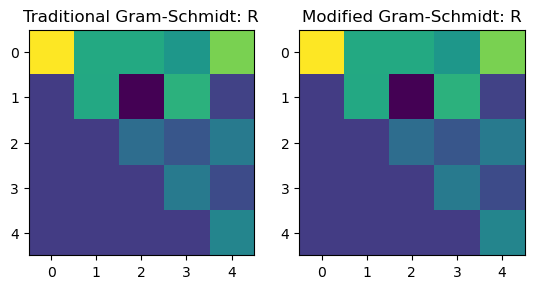

In [155]:
class QRFactorizationSolver:
    """
    Solver a linear problem using preconditioning with QR factorization. Implements both
    the traditional Gram-Schmidt process and the modified Gram-Schmidt process.

    Attributes:
        store_history (bool): Whether to store the history of the QR factorization.
        history (list): A list of tuples containing the Q and R matrices at each iteration.
    """

    def __init__(self, store_history=True):
        self.store_history = store_history

        if self.store_history:
            self.history = []
    
    def qr0(self, X):
        """
        Perform QR factorization using classical Gram-Schmidt process.
        """
        self.Q = np.copy(X) # Orthonormal vectors will be stored here
        self.R = np.zeros_like(X, dtype=float)

        ## Store the initial guess
        if self.store_history:
            self.history.append([self.Q.copy(), self.R.copy()])

        # Loop over column vectors
        for i in range(X.shape[1]):

            # pick out the i-th column vector as the pivot
            v = np.copy(X[:, i])
            
            # Sweep over all previous Q-vectors and subtract off the projections
            # This can be vectorized, but we'll do it in a loop for clarity
            for j in range(i):
                self.R[j, i] = np.dot(self.Q[:, j], X[:, i])
                v -= self.R[j, i] * self.Q[:, j]
            
            self.R[i, i] = np.linalg.norm(v)
            self.Q[:, i] = v / self.R[i, i]

            if self.store_history:
                self.history.append([self.Q.copy(), self.R.copy()])

        return self.Q, self.R

    # Loop over column vectors
    def qr(self, X):
        self.Q = np.copy(X)  # initial guess is just the original basis
        self.R = np.zeros_like(X, dtype=float)

        ## Store the initial guess
        if self.store_history:
            self.history.append([self.Q.copy(), self.R.copy()])

        for i in range(X.shape[1]):

            # Calculate diagonal element of R before normalizing Q
            self.R[i, i] = np.linalg.norm(self.Q[:, i])

            # Normalize the i-th column of Q
            self.Q[:, i] /= self.R[i, i]

            # Loop to update remaining columns by removing the i-th column component
            # along each of the previous columns
            for j in range(i + 1, X.shape[1]):
                self.R[i, j] = np.dot(self.Q[:, i], self.Q[:, j])
                self.Q[:, j] -= self.R[i, j] * self.Q[:, i]

            if self.store_history:
                self.history.append([self.Q.copy(), self.R.copy()])

        return self.Q, self.R

    def solve(self, A, b):
        """
        Solve Ax = b using QR factorization. We can see the
        factorization as a form of preconditioning for the linear solver
        """
        Q = self.qr(A)[0]
        y = np.dot(Q.T, b)
        return np.linalg.solve(self.R, y) # O(N^2) solve because R is upper triangular
        
    def test_qr(self):
        """
        Test the QR factorization solver
        """
        a = np.random.randn(3, 3)
        q, r = self.qr(a)
        assert np.allclose(a, q @ r)

    def test_solver(self):
        A = np.random.randn(5, 5)
        b = np.random.randn(5)
        x = self.solve(A, b)
        assert np.allclose(np.dot(A, x), b)


a = np.random.random((5, 5))

model = QRFactorizationSolver()

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(
    model.qr0(a)[0]
)
plt.title('Traditional Gram-Schmidt: Q')
plt.subplot(1, 2, 2)
plt.imshow(
    model.qr(a)[0]
)
plt.title('Modified Gram-Schmidt: Q')


plt.figure()
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(
    model.qr0(a)[1]
)
plt.title('Traditional Gram-Schmidt: R')
plt.subplot(1, 2, 2)
plt.imshow(
    model.qr(a)[1]
)
plt.title('Modified Gram-Schmidt: R')

print(np.allclose(model.qr0(a)[0], model.qr(a)[0]))

We can visualize the difference between Gram-Schmidt and Modified Gram-Schmidt by inspecting how the columnspace changes at each iteration of the algorithm

In [160]:
np.random.seed(0)
A = np.random.random((100, 100))

model_trad = QRFactorizationSolver(store_history=True)
q_trad, r_trad = model_trad.qr0(A.copy())
qr_trad_history = np.array(model_trad.history)

model_mod = QRFactorizationSolver(store_history=True)
q_mod, r_mod = model_mod.qr(A.copy())
qr_mod_history = np.array(model_mod.history)

To understand the difference between the two algorithms, we can visualize how the column space of the matrix $Q_k$ changes at each iteration.

In [1]:
## Make an interactive video
from ipywidgets import interact, Layout
import ipywidgets as widgets

def plotter(i):
    amat = qr_trad_history[i][0]
    amat /= np.linalg.norm(amat, axis=0, keepdims=True)
    plt.figure()
    plt.plot([0, amat[:, 0][0]], [0, amat[:, 0][1]])
    plt.plot([0, amat[:, 10][0]], [0, amat[:, 20][1]])
    plt.plot([0, amat[:, 10][0]], [0, amat[:, 40][1]])
    plt.plot([0, amat[:, 50][0]], [0, amat[:, 60][1]])
    plt.plot([0, amat[:, 99][0]], [0, amat[:, 99][1]])
    plt.text(0.1, 0.1, str(i), fontsize=20)
    plt.xlim([-0.15, 0.15])
    plt.ylim([-0.15, 0.15])
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(qr_trad_history) - 1, 1, layout=Layout(width='800px'))
)


def plotter(i):
    amat = qr_mod_history[i][0]
    amat /= np.linalg.norm(amat, axis=0, keepdims=True)
    plt.figure()
    plt.plot([0, amat[:, 0][0]], [0, amat[:, 0][1]])
    plt.plot([0, amat[:, 10][0]], [0, amat[:, 20][1]])
    plt.plot([0, amat[:, 10][0]], [0, amat[:, 40][1]])
    plt.plot([0, amat[:, 50][0]], [0, amat[:, 60][1]])
    plt.plot([0, amat[:, 99][0]], [0, amat[:, 99][1]])
    ## label current pivot index of the QR factorization overlaid on graph as text
    plt.text(0.1, 0.1, str(i), fontsize=20)
    plt.xlim([-0.15, 0.15])
    plt.ylim([-0.15, 0.15])
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(qr_trad_history) - 1, 1, layout=Layout(width='800px'))
)

NameError: name 'qr_trad_history' is not defined

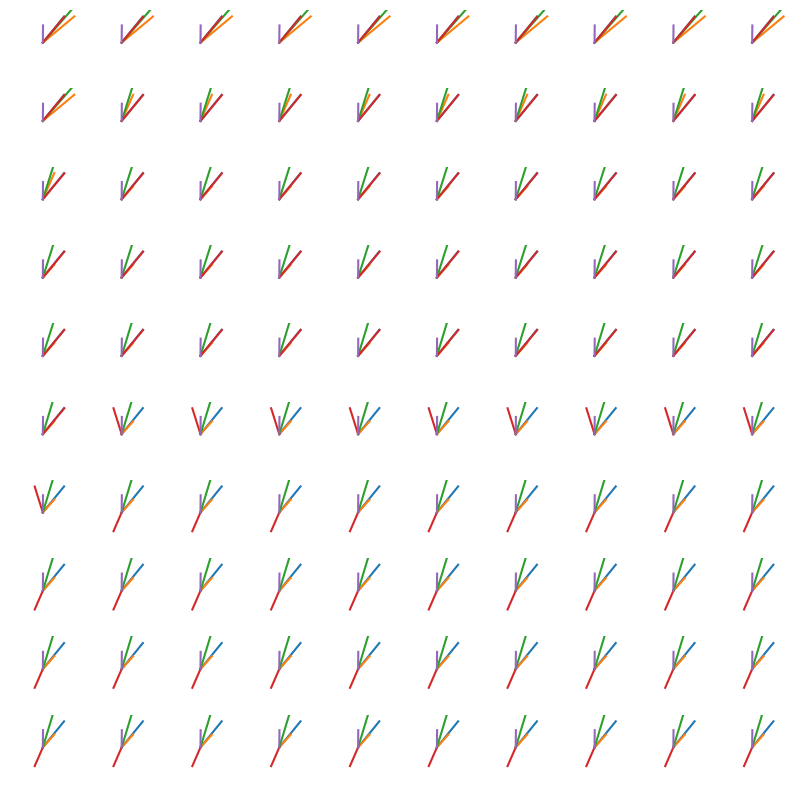

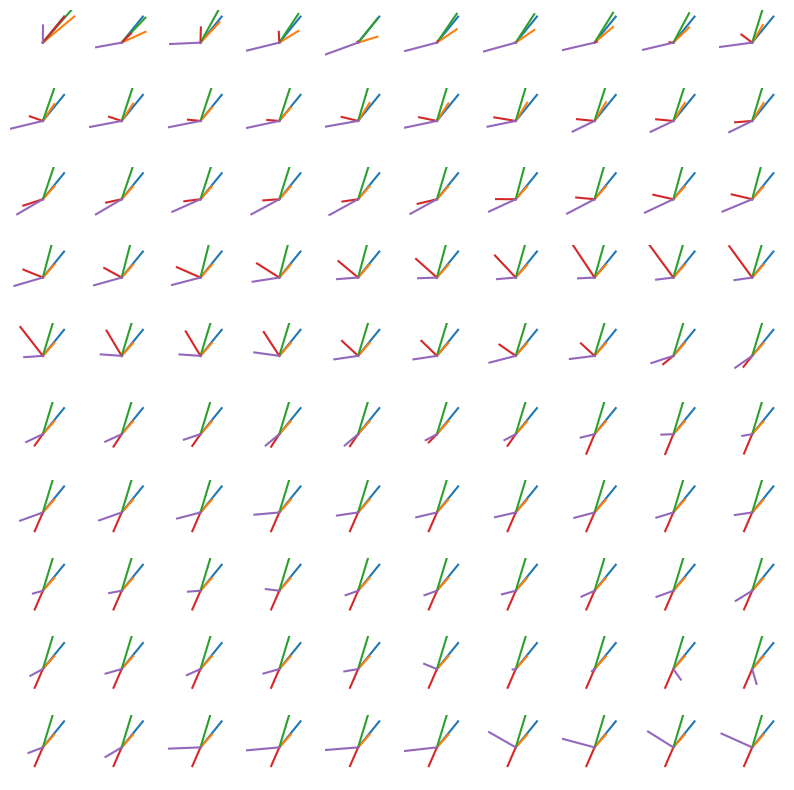

In [72]:
## plot still frames
plt.figure(figsize=(10, 10))
for i in range(0, len(qr_trad)-1, 1):
    plt.subplot(10, 10, i+1)
    amat = qr_trad[i]
    amat /= np.linalg.norm(amat, axis=0, keepdims=True)
    plt.plot([0, amat[:, 0][0]], [0, amat[:, 0][1]])
    plt.plot([0, amat[:, 10][0]], [0, amat[:, 20][1]])
    plt.plot([0, amat[:, 10][0]], [0, amat[:, 40][1]])
    plt.plot([0, amat[:, 50][0]], [0, amat[:, 60][1]])
    plt.plot([0, amat[:, 99][0]], [0, amat[:, 99][1]])
    plt.xlim([-0.15, 0.15])
    plt.ylim([-0.15, 0.15])
    plt.axis('off')


## plot still frames
plt.figure(figsize=(10, 10))
for i in range(0, len(qr_mod)-1, 1):
    plt.subplot(10, 10, i+1)
    amat = qr_mod[i]
    amat /= np.linalg.norm(amat, axis=0, keepdims=True)
    plt.plot([0, amat[:, 0][0]], [0, amat[:, 0][1]])
    plt.plot([0, amat[:, 10][0]], [0, amat[:, 20][1]])
    plt.plot([0, amat[:, 10][0]], [0, amat[:, 40][1]])
    plt.plot([0, amat[:, 50][0]], [0, amat[:, 60][1]])
    plt.plot([0, amat[:, 99][0]], [0, amat[:, 99][1]])
    plt.xlim([-0.15, 0.15])
    plt.ylim([-0.15, 0.15])
    plt.axis('off')

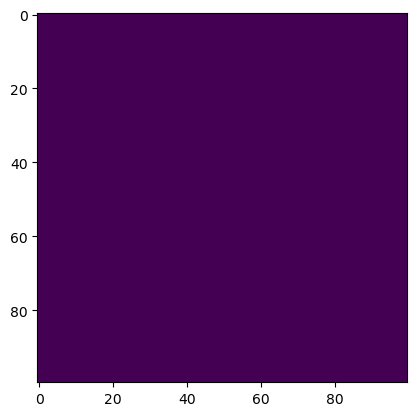

In [167]:
plt.imshow(qr_trad_history[0][1])

We can now check the condition number of the matrix, and see how it affects the error of the QR decomposition.

In [164]:
np.random.seed(0)
a = np.random.random(1000)
amp = 0.1

for amp in [1e-16, 1.0]:
    print("Amplitude: ", amp)

    ## Build an ill-conditioned matrix by repeating the bearing vector a and adding noise
    aa = np.tile(a, (len(a), 1)).T + np.random.random(size=(len(a), len(a))) * amp
    print("Condition number: ", np.linalg.cond(aa))

    model = QRFactorizationSolver()
    
    q, r = model.qr0(aa)
    # q, r = qr_factorization(aa)
    print("Traditional Error: ", np.linalg.norm(q @ r - aa))

    q, r = model.qr(aa)
    # q, r = qr_factorization(aa)
    print("Modified Error: ", np.linalg.norm(q @ r - aa))

    print("\n")

Amplitude:  1e-16
Condition number:  4.352857408842419e+20
Traditional Error:  3.72760457388773e-11
Modified Error:  6.268189545604392e-14


Amplitude:  1.0
Condition number:  1338562.4891387518
Traditional Error:  1.0148794352650185e-12
Modified Error:  1.0136881893502672e-12




Because we stored all the intermediate values of the QR factorization, we can create a time series how the condition number of the intermediate matrices $A_k$ changes as we perform the QR algorithm

Text(0, 0.5, 'Condition number')

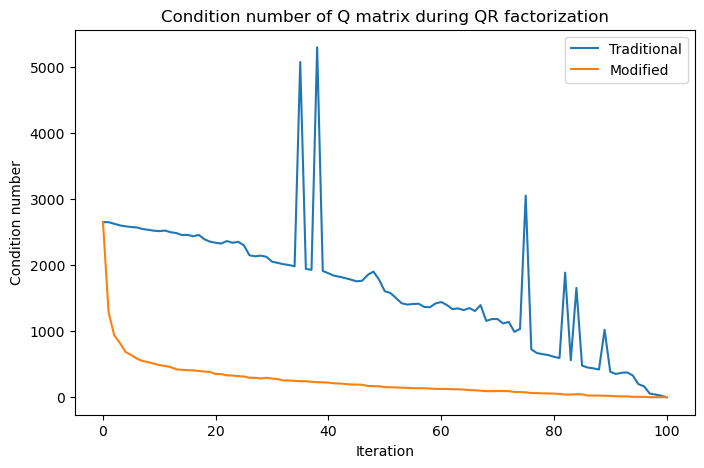

In [34]:

all_cond_trad = list()
all_cond_mod = list()
for i in range(0, len(qr_trad)):
    all_cond_trad.append(np.linalg.cond(qr_trad[i]))
    all_cond_mod.append(np.linalg.cond(qr_mod[i]))

plt.figure(figsize=(8, 5))
plt.plot(all_cond_trad, label='Traditional')
plt.plot(all_cond_mod, label='Modified')
plt.legend()
plt.title('Condition number of Q matrix during QR factorization')
plt.xlabel('Iteration')
plt.ylabel('Condition number')

## Community detection  on the co-authorship network of physicists

+ We revisit the network consisting of coauthorship among physicists based arXiv postings in `astro-ph`
+ The graph contains $N = 18772$ nodes, which correspond to unique authors observed over the period 1993 -- 2003
+ If Author i and Author j coauthored a paper during that period, the nodes are connected
+ In order to analyze this large graph, we will downsample it to a smaller graph with $N = 1000$ nodes representing the most highly-connected authors
+ This dataset is from the [Stanford SNAP database](https://snap.stanford.edu/data/ca-CondMat.html)


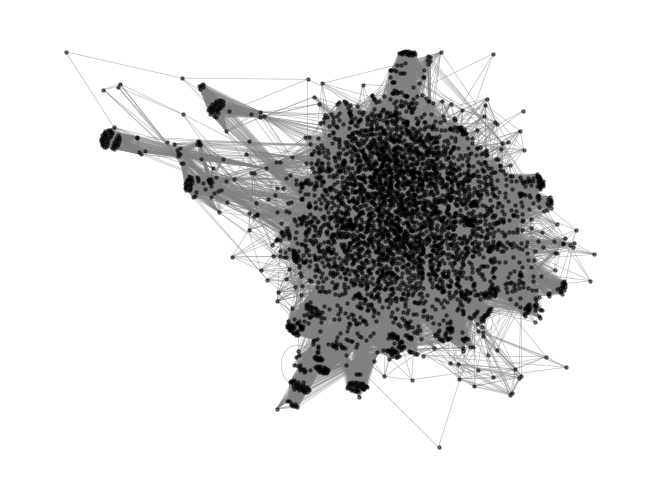

In [2]:
import io
import gzip
import urllib.request
import networkx as nx

# subject = "CondMat"
# subject = "HepPh"
# subject = "HepTh"
# subject = "GrQc"
subject = "AstroPh"
url = f"https://snap.stanford.edu/data/ca-{subject}.txt.gz"

with urllib.request.urlopen(url) as resp:
    with gzip.open(io.BytesIO(resp.read()), mode="rt") as fh:
        g = nx.read_edgelist(fh, comments="#", nodetype=int)

## Load the full coauthorship network
# fpath = "../resources/ca-AstroPh.txt.gz"
# fpath = "../resources/ca-CondMat.txt.gz"
# g = nx.read_edgelist(fpath)

## Create a subgraph of the 1000 most connected authors
subgraph = sorted(g.degree, key=lambda x: x[1], reverse=True)[:4000]
subgraph = [x[0] for x in subgraph]
g2 = g.subgraph(subgraph)
# rename nodes to sequential integers as they would appear in an adjacency matrix
g2 = nx.convert_node_labels_to_integers(g2, first_label=0)

pos = nx.spring_layout(g2)
# pos = nx.kamada_kawai_layout(g2)
# nx.draw_spring(g2, pos=pos, node_size=10, node_color='black', edge_color='gray', width=0.5)
nx.draw(g2, pos=pos, node_size=5, node_color='black', edge_color='gray', width=0.5, alpha=0.5)
plt.show()

## Random walks on graphs: The ensemble limit

Recall that random walks on the co-authorship network exhibit a non-uniform invariant distribution, where the probability of visiting a node is proportional to its degree.

This is because we can interpret the adjacency matrix $A$ as a transition matrix for a Markov chain, which governs the dynamics of an ensemble of random walkers on the graph. The probability of transitioning from node $i$ to node $j$ in one step is given by  the transition matrix $P_{ij} = A_{ij} / \sum_k A_{ik}$, where the denominator is the out-degree of node $i$. Notice that even if $A$ is symmetric, $P$ is not symmetric, because the transition probability depends on the out-degree of the node.

What is the long-term behavior of this Markov chain? We can find the invariant distribution $\pi$ by solving the equation $\pi = \pi P$, which is equivalent to finding the eigenvector of $P$ with eigenvalue 1. Our definition of the Markov chain implies that we are treating the adjacency matrix as defining a Markov chain in **discrete time**

<br>
<br>
<br>
<br>


## Spectral graph analysis

We can see that there is a clump of highly-collaborative authors, and then isolated subcommunities. We can quantify this observation and these clumps using spectral analysis of the graph

We define the adjacency matrix $A$ of the graph as a matrix where $A_{ij} = 1$ if nodes $i$ and $j$ are connected, and $A_{ij} = 0$ otherwise. We define a Markov transition matrix from this adjacency matrix as 

$$
T_{ij} = \frac{A_{ij}}{\sum_k A_{ik}}
$$

where the denominator is the total number of connections for node $i$. This matrix is row-stochastic, meaning that the sum of each row is 1. This matrix represents a random walk on the graph, where at each step, we randomly select a neighbor of the current node, and then move to that node. The probability of moving to a given node is proportional to the number of connections that node has to the current node.

/Users/william/micromamba/envs/cphy/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/william/micromamba/envs/cphy/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


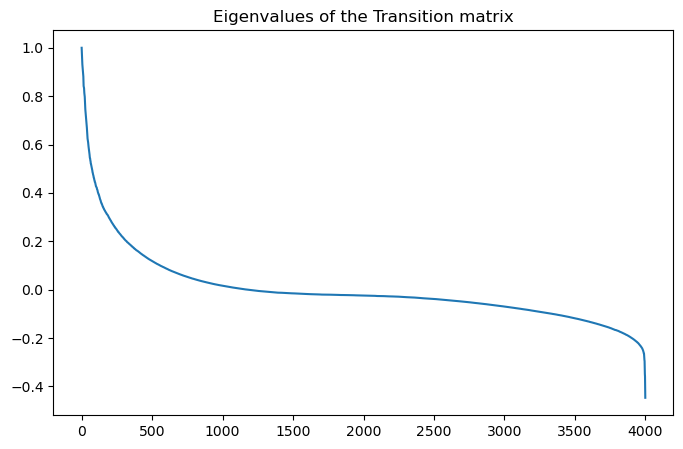

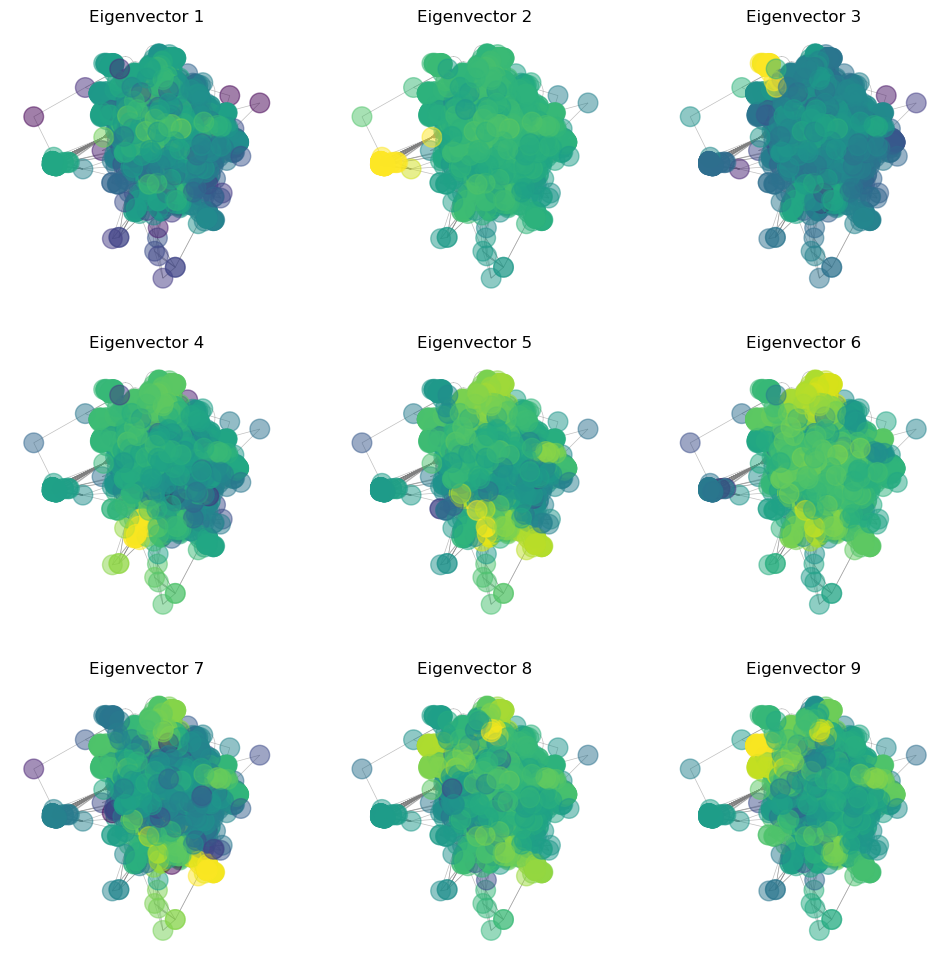

In [27]:
# use spectral graph partitioning 

## Create the adjacency matrix
A = nx.adjacency_matrix(g2).todense()
A = np.array(A)

# convert to discrete-time Markov transition matrix
T = A / np.sum(A, axis=0, keepdims=True)

## Create the degree matrix
# D = np.diag(np.sum(A, axis=0))
# D = np.identity(A.shape[0]) # unweighted graph

## Create the graph Laplacian matrix
# L = D - A

## Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(T)

## Sort the eigenvalues and eigenvectors
sort_inds = np.argsort(eigenvalues)[::-1]
eigenvalues, eigenvectors = eigenvalues[sort_inds], eigenvectors[:, sort_inds]

## Plot the eigenvalues in descending order
plt.figure(figsize=(8, 5))
plt.plot(eigenvalues)
plt.title("Eigenvalues of the Transition matrix")


## Plot the leading eigenvectors as colors on the graph
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    nx.draw(g2, pos=pos, node_size=200, node_color=np.log(np.abs(eigenvectors[:, i])), edge_color='gray', width=0.5, alpha=0.5)
    plt.title("Eigenvector {}".format(i+1))


## What do the different eigenvectors mean?

#### Leading Eigenvalues

+ A discrete-time Markov chain has leading eigenvector associated with the eigenvalue 1. This eigenvector represents the invariant distribution of the Markov chain, and is the long-term probability of finding the random walker at a given node. 

+ + If there are multiple disconnected subgraphs, there will be degeneracy with multiple eigenvectors associated with the eigenvalue 1.

+ The second eigenvector of the transition matrix is associated with the second-largest eigenvalue. This represents the longest-lived *transients* in the Markov chain dynamics


#### Negative Eigenvalue 
+ If there are negative eigenvalues, these indicate cycles in the graph. The eigenvectors associated with these eigenvalues represent the oscillatory behavior of the random walker as it cycles through the graph. For example, consider the transition matrix:

$$
A =
\begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}
$$

A random walker will oscillate between the two nodes. The invariant density associated with the leading eigenvalue $\lambda_1 = 1$ is given by

$$
\pi_1 = \frac{1}{2}
\begin{bmatrix}
1 \\
1
\end{bmatrix}
$$

Because, on average, the walker spends half of its time at each node. The eigenvector associated with the second eigenvalue $\lambda_2 = -1$ is given by

$$
\begin{bmatrix}
1 \\
-1
\end{bmatrix}
$$

Because the walker spends one step at the first node, and then one step at the second node, and then repeats this cycle.


###  Laplacian eigenmaps

We saw that we can associate a discrete-time Markov chain with the adjacency matrix $A$ of a graph. We can also associate a continuous-time Markov chain with the adjacency matrix of a graph. In this case, the generator matrix is defined as

$$
Q_{ij} = \begin{cases}
A_{ij} & i \neq j \\
- \sum_k A_{ik} & i = j
\end{cases}
$$

This defines a continuous-time Markov chain, with differential equation

$$
\frac{d}{dt} \pi(t) = Q \pi(t)
$$

where $\pi(t)$ is the probability distribution of the random walker at time $t$. The solution to this differential equation is given by
$$
\pi(t) = e^{Qt} \pi(0)
$$
where $e^{Qt}$ is the matrix exponential. 

The generator matrix $Q$ is related to the transition matrix $P$ by the relation $Q = P - \mathbb{I}$, where $\mathbb{I}$ is the identity matrix. This means that the eigenvalues of $Q$ are related to the eigenvalues of $P$ by $\lambda_Q = \lambda_P - 1$. This means that the leading eigenvalue of $Q$ is 0, and the leading eigenvector of $Q$ is the same as the leading eigenvector of $P$.

### The Graph Laplacian

The graph Laplacian is defined as

$$
L = D - A
$$

where $D$ is a diagonal matrix, where $D_{ii}$ is the degree of node $i$. The graph Laplacian is a symmetric matrix, and so it has a complete set of orthonormal eigenvectors. The eigenvectors of the graph Laplacian are related to the eigenvectors of the transition matrix $P$ by

$$
\phi_i = \frac{1}{\sqrt{d_i}} \psi_i
$$

where $d_i$ is the degree of node $i$.

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

def amat_to_dist(A, *, directed=True, unweighted=True,
                 unreachable_value=1e10, out_dtype=np.float32):
    """
    Args:
        A (array_like or sparse): N×N adjacency/weight matrix.
        directed (bool): Treat graph as directed.
        unweighted (bool): If True, any nonzero entry is an edge of weight 1.
        unreachable_value (float): Value to use when no path exists.
        out_dtype (np.dtype): dtype of the returned distance matrix.

    Returns:
        np.ndarray: N×N matrix of shortest-path distances.
    """
    A_csr = csr_matrix(A)
    D = shortest_path(A_csr, directed=directed, unweighted=unweighted)
    D = D.astype(out_dtype, copy=False)
    if np.isinf(D).any():
        D[np.isinf(D)] = out_dtype.type(unreachable_value) if hasattr(out_dtype, "type") else unreachable_value
    return D

Text(0.5, 1.0, 'Laplacian Eigenmap')

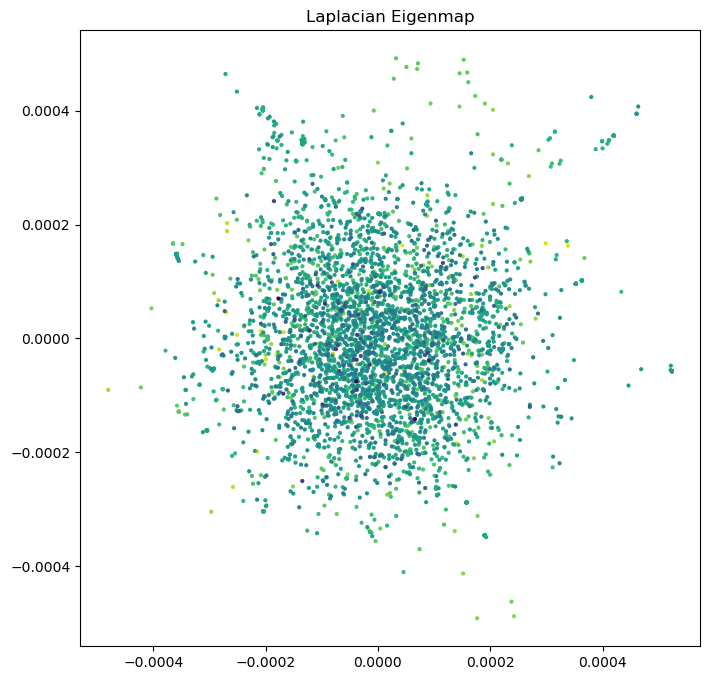

In [5]:
import networkx as nx

from scipy.sparse.linalg import eigs
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

class LaplacianEigenmap:
    """
    A class for computing the Laplacian Eigenmap of a graph

    Attributes:
        n_components (int): The number of components to return.
    """

    def __init__(self, n_components=2):
        self.n_components = n_components

    def amat_to_dist(self, A, directed=False, unweighted=True, unreachable_value=1e10, out_dtype=np.float32):
        """convert adjacency matrix to distance matrix with shortest path"""
        A_csr = csr_matrix(A)
        D = shortest_path(A_csr, directed=directed, unweighted=unweighted)
        D = D.astype(out_dtype, copy=False)
        if np.isinf(D).any():
            D[np.isinf(D)] = out_dtype.type(unreachable_value) if hasattr(out_dtype, "type") else unreachable_value
        return D

    def fit_transform(self, A):
        # A is the adjacency matrix

        # Convert adjacency matrix to distance matrix
        A = self.amat_to_dist(A)
        
        # Compute degree matrix
        D = np.diag(np.sum(A, axis=1)).astype(float)
        
        # Compute Laplacian matrix
        L = (D - A).astype(float)
        
        # Eigendecomposition
        vals, vecs = eigs(csr_matrix(L, dtype='float64'), k=self.n_components + 1, 
                          M=csr_matrix(D, dtype='float64'), which='SM')
        
        # Sort eigenpairs and get relevant eigenvectors
        sorted_indices = np.argsort(vals.real)
        relevant_indices = sorted_indices[1:self.n_components + 1]  # Exclude smallest eigenvalue
        
        # Projected data
        Y = vecs[:, relevant_indices].real
        return Y


model = LaplacianEigenmap(n_components=2)


A = nx.adjacency_matrix(g2).todense()
A = np.array(A)
degrees = np.sum(A, axis=1)
sort_inds = np.argsort(degrees)[::-1]
A = A[sort_inds][:, sort_inds]
Y = model.fit_transform(A)

plt.figure(figsize=(8, 8))
plt.scatter(Y[:, 0], Y[:, 1], s=4, c=np.log(degrees[sort_inds]))
plt.title("Laplacian Eigenmap")


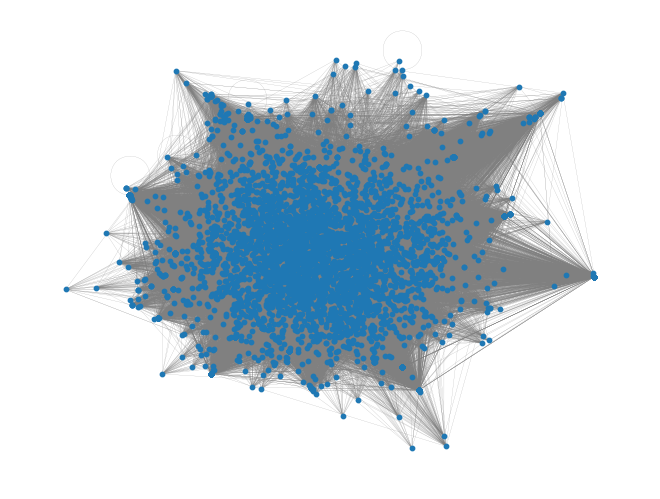

In [ ]:
nx.draw(g2, pos=Y, node_size=10, edge_color='gray', width=0.1)

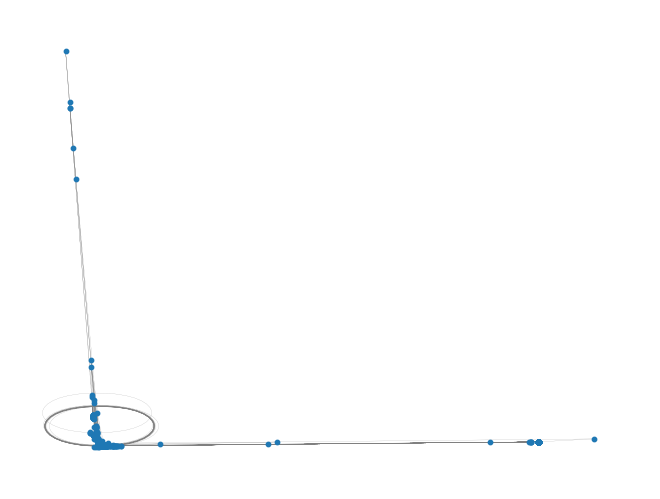

In [12]:
pos2 = nx.spectral_layout(g2)
nx.draw(g2, pos=pos2, node_size=10, edge_color='gray', width=0.1)

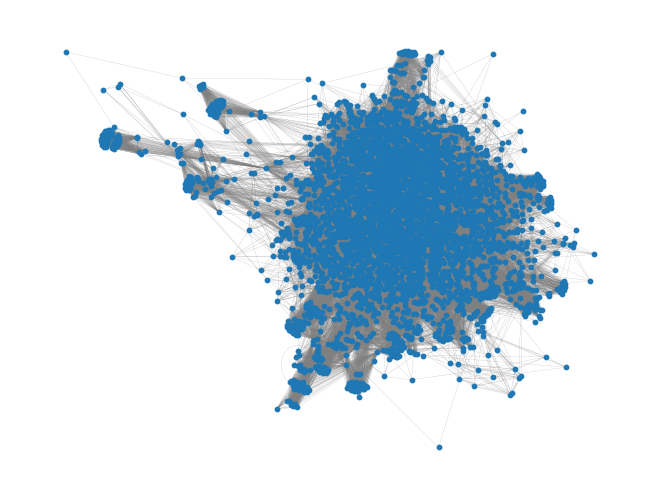

In [10]:
nx.draw(g2, pos=pos, node_size=10, edge_color='gray', width=0.1)

Text(0.5, 1.0, 'Laplacian Eigenmap')

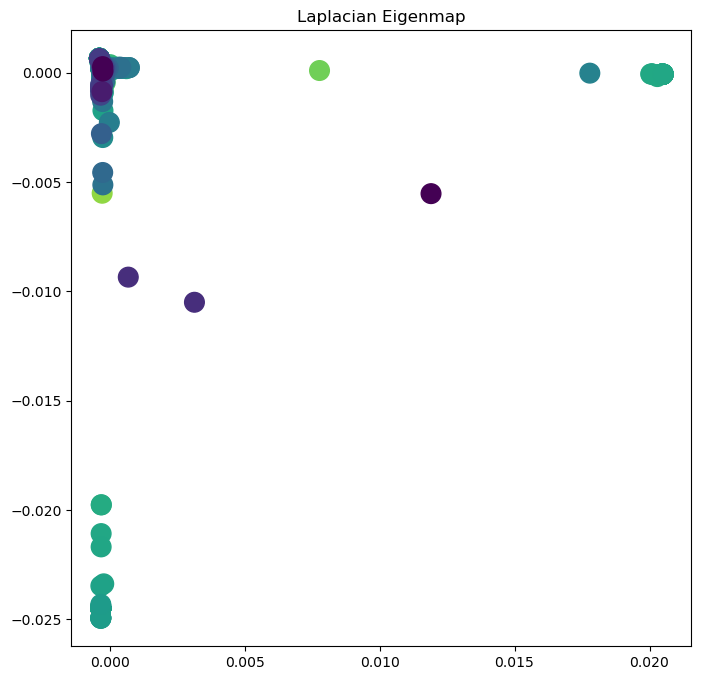

In [180]:

plt.figure(figsize=(8, 8))
plt.scatter(Y[:, 0], Y[:, 1], s=200, c=np.log(degrees[sort_inds]))
plt.title("Laplacian Eigenmap")

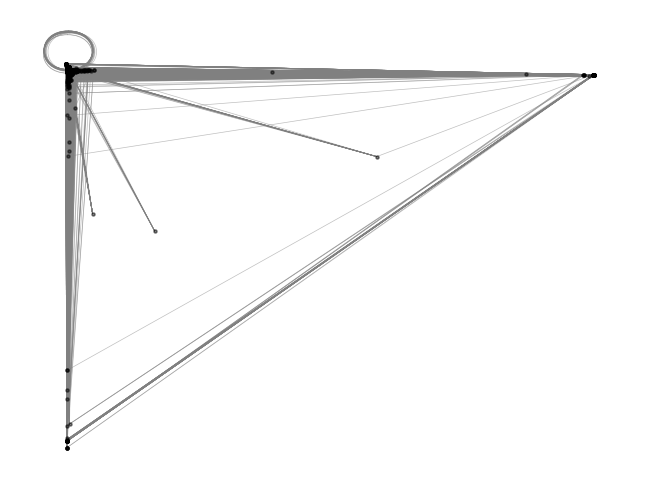

In [182]:
# pos = nx.spring_layout(g2)
# pos = nx.kamada_kawai_layout(g2)
# nx.draw_spring(g2, pos=pos, node_size=10, node_color='black', edge_color='gray', width=0.5)
nx.draw(g2, pos=Y, node_size=5, node_color='black', edge_color='gray', width=0.5, alpha=0.5)
plt.show()

## How do we interpret the eigenspectrum of a graph?

+ The eigenvecors of the adjacency matrix of a graph represent the "modes" of the graph

+ The graph adjacency matrix can be used to define a Markov process on the graph, which evolves a probability distribution of random walkers over the nodes of the graph. 

+ The leading eigenvector of the adjacency matrix represents the stationary distributions of this Markov process, while the subsequent eigenvectors represent long-lived transients

+ The first eigenvector thus gives the long-term probability distribution of which nodes random walkers will be found on, and so it can be used as a loose ranking of the importance of nodes in the graph

### How do we visualize graphs?

In [168]:
class MultidimensionalScaling:

    def __init__(self, A):
        self.A = A

    def adj_to_dist(self, A):
        """
        Convert an unweighted adjacency matrix to a distance matrix using the
        shortest path distance between nodes.
        """
        # dijkstra's algorithm
        dist = np.zeros_like(A, dtype=float)
        for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                if i == j:
                    continue
                if A[i, j] == 0:
                    dist[i, j] = np.inf
                else:
                    dist[i, j] = 1
        for k in range(A.shape[0]):
            for i in range(A.shape[0]):
                for j in range(A.shape[0]):
                    dist[i, j] = min(dist[i, j], dist[i, k] + dist[k, j])
        return dist

    def fit_transform(self, n_components=2):
        """
        Fit the MDS model to the data

        Args:
            n_components (int): The number of dimensions to project into.

        Returns:
            X (numpy.ndarray): The projected data.
        """
        n = self.A.shape[0]
        dim = n_components

        dmat = self.adj_to_dist(self.A)
        
        # Step 1: Create the centering matrix
        H = np.eye(n) - np.ones((n, n)) / n
        
        # Step 2: Apply double centering
        B = -0.5 * np.dot(H, np.dot(dmat ** 2, H))
        
        # Step 3: Eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(B)
        
        # Step 4: Sort and select top k eigenvalues and eigenvectors
        sorted_idx = np.argsort(eigenvalues)[::-1]
        lambda_sqrt = np.sqrt(np.diag(eigenvalues[sorted_idx][:dim]))
        E = eigenvectors[:, sorted_idx][:, :dim]
        
        # Step 5: Compute coordinates
        X = np.dot(E, lambda_sqrt)
        
        return X

model = MultidimensionalScaling(A)
X_pos = model.fit_transform(n_components=2)

plt.figure(figsize=(12, 12))
plt.plot(X_pos[:, 0], X_pos[:, 1], '.')

KeyboardInterrupt: 